 # Notebook 5: Linguistic Features

 ## Purpose
 - Sentiment analysis (overall + per demographic group)
 - Emotion detection
 - Subjectivity scoring
 - Part-of-speech analysis
 - Lexical diversity metrics

 ## Inputs
 - `data/processed/articles_with_events.csv`

 ## Outputs
 - `data/processed/linguistic_features.parquet`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from collections import Counter
import re

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported")

Libraries imported


In [2]:
# Download required NLTK data
print("Downloading NLTK data...")
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('averaged_perceptron_tagger', quiet=True)

print("NLTK data ready")

NLTK data ready


In [3]:
# Paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'linguistic_features.parquet'

 ## 1. Load Data

In [4]:
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df):,} articles")

text_column = 'article_text' if 'article_text' in df.columns else 'text'
df['text_for_analysis'] = df[text_column].fillna('')

Loading data...
Loaded 49,926 articles


/var/folders/9s/6vlynz8d6hzbq58p0sbxfjc174vfgt/T/ipykernel_18522/248979150.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


 ## 2. Sentiment Analysis with VADER

In [5]:
print("\nPerforming sentiment analysis with VADER...")

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores


def get_vader_sentiment(text):
    if not text:
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    scores = sia.polarity_scores(text)
    return scores


# Apply to all articles
sentiment_results = df['text_for_analysis'].apply(get_vader_sentiment)
df['sentiment_negative'] = sentiment_results.apply(lambda x: x['neg'])
df['sentiment_neutral'] = sentiment_results.apply(lambda x: x['neu'])
df['sentiment_positive'] = sentiment_results.apply(lambda x: x['pos'])
df['sentiment_compound'] = sentiment_results.apply(lambda x: x['compound'])

# Classify overall sentiment


def classify_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'


df['sentiment_category'] = df['sentiment_compound'].apply(classify_sentiment)

print("VADER sentiment analysis complete")


Performing sentiment analysis with VADER...
VADER sentiment analysis complete


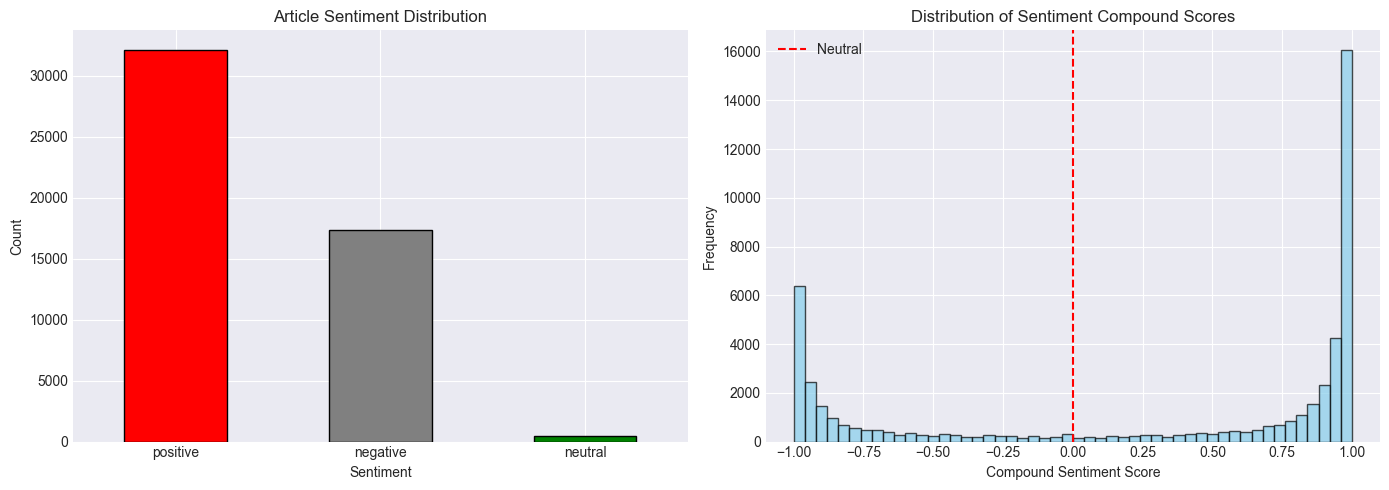

In [6]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentiment categories
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_counts.plot(kind='bar', ax=axes[0], color=['red', 'gray', 'green'], edgecolor='black')
axes[0].set_title('Article Sentiment Distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Compound score distribution
df['sentiment_compound'].hist(bins=50, ax=axes[1], edgecolor='black', alpha=0.7, color='skyblue')
axes[1].set_xlabel('Compound Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Sentiment Compound Scores')
axes[1].axvline(0, color='red', linestyle='--', label='Neutral')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Key Insights: Article sentiment distribution and compound scores (VADER)

1) The left bar chart shows that a clear majority of articles are classified as positive, with a substantial minority negative and only a small fraction neutral, indicating that overall tone skews positive in this corpus.

2) The right histogram plots the continuous compound sentiment scores with a red line at zero, letting you see how scores spread around neutrality and confirming that values are more densely packed on the positive side of the scale.

 ## 3. Subjectivity Analysis with TextBlob

In [7]:
print("\nAnalyzing subjectivity with TextBlob...")


def get_textblob_features(text):
    if not text:
        return {'polarity': 0, 'subjectivity': 0}
    try:
        blob = TextBlob(text)
        return {
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        }
    except:
        return {'polarity': 0, 'subjectivity': 0}


# Apply to all articles
textblob_results = df['text_for_analysis'].apply(get_textblob_features)
df['textblob_polarity'] = textblob_results.apply(lambda x: x['polarity'])
df['textblob_subjectivity'] = textblob_results.apply(lambda x: x['subjectivity'])

# Classify subjectivity
df['is_subjective'] = (df['textblob_subjectivity'] > 0.5).astype(int)
df['is_objective'] = (df['textblob_subjectivity'] <= 0.5).astype(int)

print("Subjectivity analysis complete")
print(f"  Subjective articles: {df['is_subjective'].sum():,} ({df['is_subjective'].mean() * 100:.1f}%)")
print(f"  Objective articles: {df['is_objective'].sum():,} ({df['is_objective'].mean() * 100:.1f}%)")


Analyzing subjectivity with TextBlob...
Subjectivity analysis complete
  Subjective articles: 6,300 (12.6%)
  Objective articles: 43,626 (87.4%)


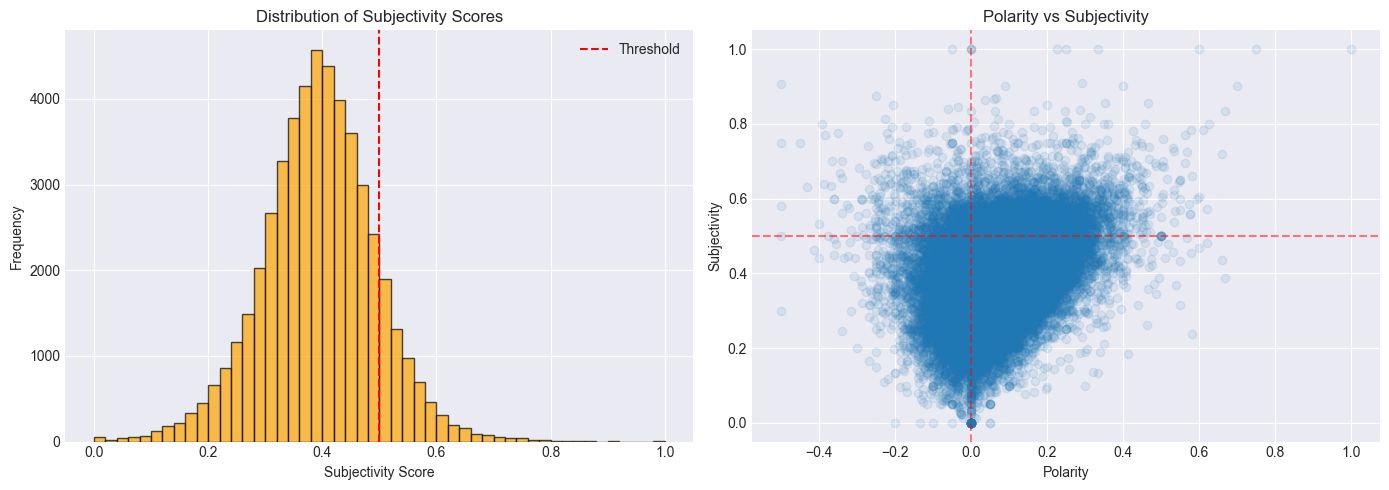

In [8]:
# Visualize subjectivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subjectivity distribution
df['textblob_subjectivity'].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel('Subjectivity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Subjectivity Scores')
axes[0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0].legend()

# Polarity vs Subjectivity
axes[1].scatter(df['textblob_polarity'], df['textblob_subjectivity'], alpha=0.1)
axes[1].set_xlabel('Polarity')
axes[1].set_ylabel('Subjectivity')
axes[1].set_title('Polarity vs Subjectivity')
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Key Insights: Subjectivity and polarity patterns

1) The subjectivity histogram peaks between about 0.3 and 0.5, mostly below the 0.5 threshold, indicating that the majority of articles are relatively objective or only mildly subjective.

2) The polarity–subjectivity scatter is densest around polarity ≈ 0 and subjectivity ≈ 0.4, showing that strongly opinionated and highly positive/negative articles are relatively rare compared to neutral-toned pieces.

 ## 4. Emotion Detection (Basic)

In [9]:
print("\nDetecting emotions...")

# Emotion lexicons (simplified)
EMOTION_LEXICONS = {
    'anger': ['angry', 'furious', 'rage', 'outrage', 'mad', 'annoyed', 'irritated', 'hostile'],
    'fear': ['fear', 'afraid', 'scared', 'anxious', 'worried', 'nervous', 'terror', 'panic'],
    'joy': ['happy', 'joy', 'delight', 'pleased', 'cheerful', 'excited', 'glad'],
    'sadness': ['sad', 'unhappy', 'depressed', 'miserable', 'grief', 'sorrow', 'despair'],
    'disgust': ['disgust', 'revolting', 'repulsive', 'sickening', 'nauseating'],
    'surprise': ['surprise', 'amazed', 'astonished', 'shocked', 'stunned']
}


def count_emotion_words(text, emotion_words):
    if not text:
        return 0
    text_lower = text.lower()
    count = 0
    for word in emotion_words:
        pattern = r'\b' + re.escape(word) + r'\b'
        count += len(re.findall(pattern, text_lower))
    return count


# Calculate emotion scores
for emotion, words in EMOTION_LEXICONS.items():
    df[f'emotion_{emotion}_count'] = df['text_for_analysis'].apply(
        lambda x: count_emotion_words(x, words)
    )

# Dominant emotion
emotion_cols = [f'emotion_{e}_count' for e in EMOTION_LEXICONS.keys()]
df['dominant_emotion'] = df[emotion_cols].idxmax(axis=1).str.replace('emotion_', '').str.replace('_count', '')
df['dominant_emotion_score'] = df[emotion_cols].max(axis=1)

# Flag if no emotion detected
df['has_emotion'] = (df['dominant_emotion_score'] > 0).astype(int)

print("Emotion detection complete")
print(f"  Articles with emotion words: {df['has_emotion'].sum():,} ({df['has_emotion'].mean() * 100:.1f}%)")


Detecting emotions...
Emotion detection complete
  Articles with emotion words: 10,025 (20.1%)


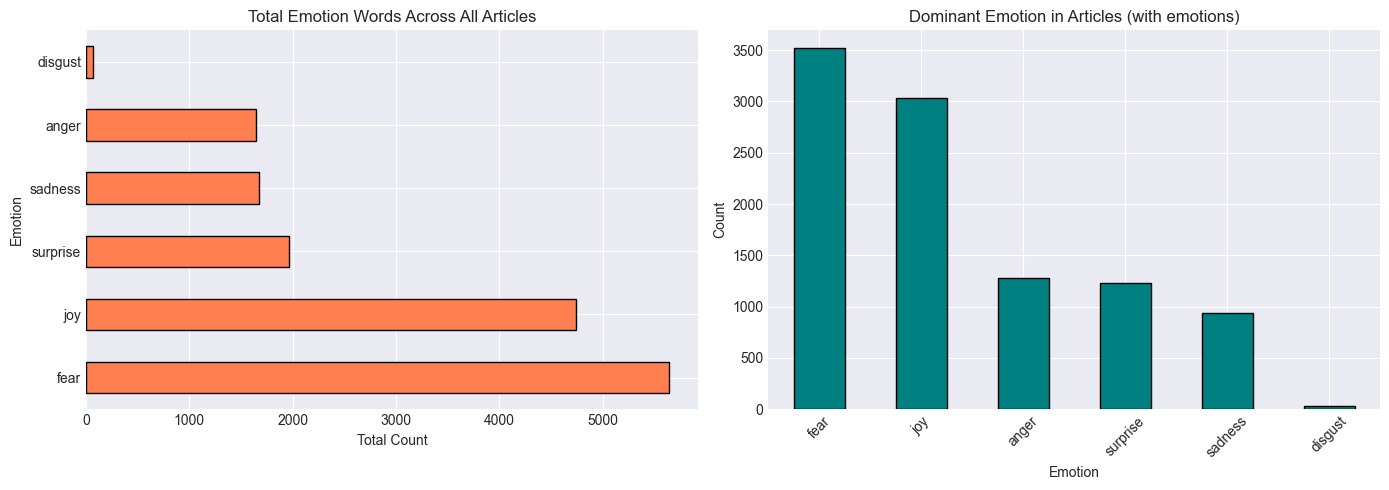

In [10]:
# Visualize emotions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Emotion counts
emotion_totals = {emotion: df[f'emotion_{emotion}_count'].sum() for emotion in EMOTION_LEXICONS.keys()}
emotion_df = pd.Series(emotion_totals).sort_values(ascending=False)
emotion_df.plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_xlabel('Total Count')
axes[0].set_ylabel('Emotion')
axes[0].set_title('Total Emotion Words Across All Articles')

# Dominant emotion distribution
dominant_with_emotion = df[df['has_emotion'] == 1]['dominant_emotion'].value_counts()
dominant_with_emotion.plot(kind='bar', ax=axes[1], color='teal', edgecolor='black')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].set_title('Dominant Emotion in Articles (with emotions)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Key Insights: Emotion word usage and dominant emotions

1) The left bar chart shows that fear and joy words appear most frequently across all articles, while emotions like disgust are almost never used, indicating coverage that is emotionally charged but rarely explicitly disgusted.

2) The right bar chart reveals that, among articles with emotion words, fear is the most common dominant emotion, followed by joy, suggesting that fearful framing slightly outweighs positive emotional framing in the corpus.

 ## 5. Part-of-Speech (POS) Analysis

In [11]:
print("\nPerforming POS analysis...")


def get_pos_features(text, sample_size=500):
    """
    Extract POS features from text
    Sample first N words for efficiency
    """
    if not text:
        return {
            'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
            'adv_ratio': 0, 'pronoun_ratio': 0
        }

    try:
        # Tokenize and sample
        words = nltk.word_tokenize(text.lower())
        if len(words) > sample_size:
            words = words[:sample_size]

        # POS tagging
        pos_tags = nltk.pos_tag(words)

        # Count POS categories
        pos_counts = Counter([tag for word, tag in pos_tags])
        total = len(pos_tags)

        if total == 0:
            return {'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
                    'adv_ratio': 0, 'pronoun_ratio': 0}

        # Calculate ratios
        nouns = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('NN'))
        verbs = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('VB'))
        adjectives = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('JJ'))
        adverbs = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('RB'))
        pronouns = sum(pos_counts[tag] for tag in pos_counts if tag.startswith('PRP'))

        return {
            'noun_ratio': nouns / total,
            'verb_ratio': verbs / total,
            'adj_ratio': adjectives / total,
            'adv_ratio': adverbs / total,
            'pronoun_ratio': pronouns / total
        }
    except:
        return {'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
                'adv_ratio': 0, 'pronoun_ratio': 0}


# Apply POS analysis (sample for efficiency)
print("  Processing sample of articles for POS...")
sample_indices = df.sample(min(10000, len(df)), random_state=42).index
pos_results = df.loc[sample_indices, 'text_for_analysis'].apply(get_pos_features)

# Initialize columns
for feature in ['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'pronoun_ratio']:
    df[feature] = 0.0

# Fill sample results
df.loc[sample_indices, 'noun_ratio'] = pos_results.apply(lambda x: x['noun_ratio'])
df.loc[sample_indices, 'verb_ratio'] = pos_results.apply(lambda x: x['verb_ratio'])
df.loc[sample_indices, 'adj_ratio'] = pos_results.apply(lambda x: x['adj_ratio'])
df.loc[sample_indices, 'adv_ratio'] = pos_results.apply(lambda x: x['adv_ratio'])
df.loc[sample_indices, 'pronoun_ratio'] = pos_results.apply(lambda x: x['pronoun_ratio'])

print("POS analysis complete (sampled)")
print(f"  Analyzed: {len(sample_indices):,} articles")


Performing POS analysis...
  Processing sample of articles for POS...
POS analysis complete (sampled)
  Analyzed: 10,000 articles


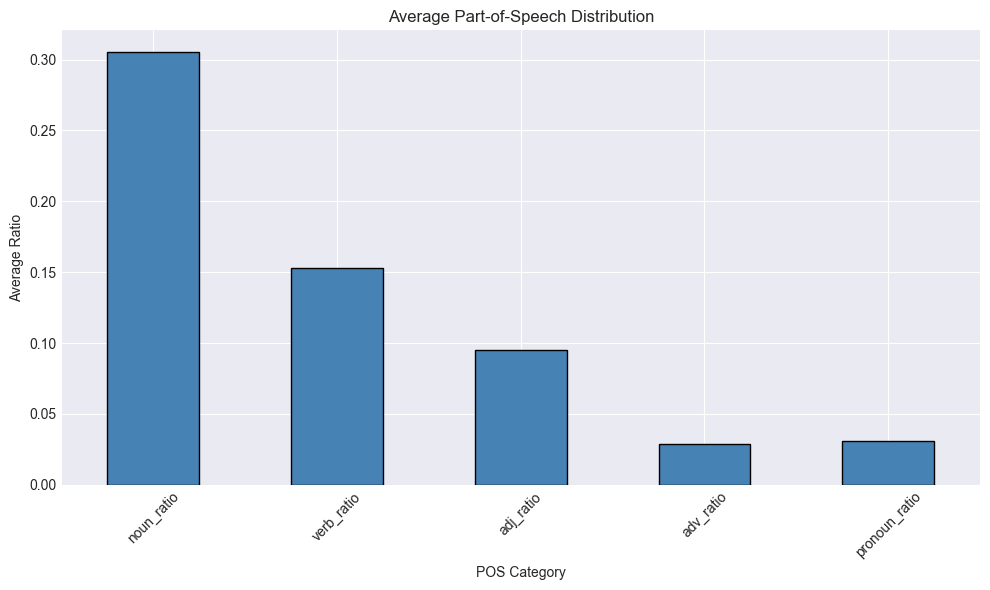

In [12]:
# Visualize POS distribution
pos_cols = ['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'pronoun_ratio']
pos_means = df.loc[sample_indices, pos_cols].mean()

fig, ax = plt.subplots(figsize=(10, 6))
pos_means.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('POS Category')
ax.set_ylabel('Average Ratio')
ax.set_title('Average Part-of-Speech Distribution')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Key Insights: Average part‑of‑speech distribution

1) Nouns dominate the mix, followed by verbs and adjectives, indicating the articles focus heavily on entities, actions, and descriptive details.

2) Adverbs and pronouns occur much less frequently, suggesting a more factual, impersonal writing style with limited personal or highly embellished language.

 ## 6. Lexical Diversity

In [13]:
print("\nCalculating lexical diversity...")


def calculate_lexical_diversity(text):
    """
    Calculate Type-Token Ratio (TTR) and other diversity metrics
    """
    if not text:
        return {'ttr': 0, 'unique_words': 0, 'avg_word_length': 0}

    words = text.lower().split()
    if len(words) == 0:
        return {'ttr': 0, 'unique_words': 0, 'avg_word_length': 0}

    # Type-Token Ratio
    unique_words = len(set(words))
    ttr = unique_words / len(words)

    # Average word length
    avg_word_len = np.mean([len(word) for word in words])

    return {
        'ttr': ttr,
        'unique_words': unique_words,
        'avg_word_length': avg_word_len
    }


# Apply diversity analysis
diversity_results = df['text_for_analysis'].apply(calculate_lexical_diversity)
df['type_token_ratio'] = diversity_results.apply(lambda x: x['ttr'])
df['unique_word_count'] = diversity_results.apply(lambda x: x['unique_words'])
df['avg_word_length'] = diversity_results.apply(lambda x: x['avg_word_length'])

# Vocabulary richness category
df['vocabulary_richness'] = pd.cut(
    df['type_token_ratio'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['low', 'medium', 'high', 'very_high']
)

print("Lexical diversity calculated")
print(f"\nVocabulary richness distribution:")
print(df['vocabulary_richness'].value_counts())


Calculating lexical diversity...
Lexical diversity calculated

Vocabulary richness distribution:
vocabulary_richness
high         36447
medium        8707
very_high     4638
low            134
Name: count, dtype: int64


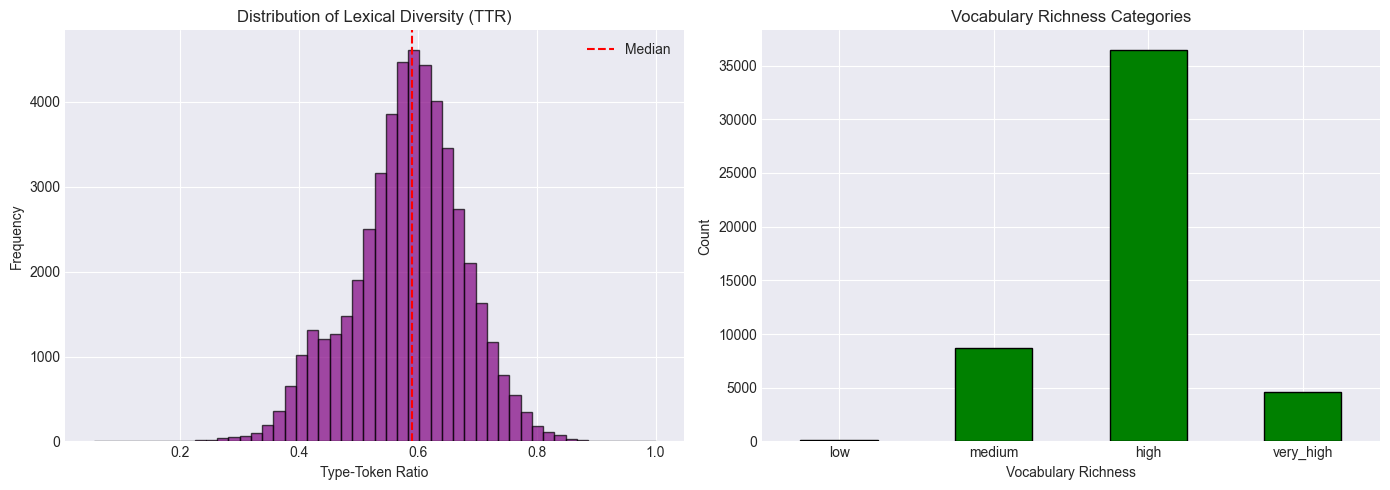

In [14]:
# Visualize lexical diversity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# TTR distribution
df['type_token_ratio'].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7, color='purple')
axes[0].set_xlabel('Type-Token Ratio')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Lexical Diversity (TTR)')
axes[0].axvline(df['type_token_ratio'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Vocabulary richness
vocab_counts = df['vocabulary_richness'].value_counts().sort_index()
vocab_counts.plot(kind='bar', ax=axes[1], color='green', edgecolor='black')
axes[1].set_xlabel('Vocabulary Richness')
axes[1].set_ylabel('Count')
axes[1].set_title('Vocabulary Richness Categories')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Key Insights: Lexical diversity and vocabulary richness

1) The TTR histogram peaks around 0.55–0.65, indicating that most articles have relatively high lexical diversity rather than being highly repetitive.

2) The vocabulary‑richness bars show that the vast majority of articles fall into the high category, with fewer medium and very_high pieces and almost no low‑richness texts.

 ## 7. Additional Linguistic Features

In [15]:
print("\nCalculating additional linguistic features...")

# Sentence count
df['sentence_count'] = df['text_for_analysis'].str.count(r'[.!?]+')

# Average sentence length (words per sentence)
df['avg_sentence_length'] = np.where(
    df['sentence_count'] > 0,
    df['text_for_analysis'].str.split().str.len() / df['sentence_count'],
    0
)

# Question count (indication of rhetorical style)
df['question_count'] = df['text_for_analysis'].str.count(r'\?')
df['question_ratio'] = df['question_count'] / df['sentence_count'].replace(0, 1)

# Exclamation count (indication of emphasis/emotion)
df['exclamation_count'] = df['text_for_analysis'].str.count(r'!')
df['exclamation_ratio'] = df['exclamation_count'] / df['sentence_count'].replace(0, 1)

# Quote count (indication of attribution/sources)
df['quote_count'] = df['text_for_analysis'].str.count(r'["\']')

# Capital letter ratio (indication of emphasis)
df['capital_ratio'] = df['text_for_analysis'].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
)

print("Additional linguistic features calculated")


Calculating additional linguistic features...
Additional linguistic features calculated


 ## 8. Feature Summary

In [16]:
# List all linguistic features
linguistic_features = [
    # Sentiment
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'sentiment_compound', 'sentiment_category',

    # Subjectivity
    'textblob_polarity', 'textblob_subjectivity',
    'is_subjective', 'is_objective',

    # Emotions
    'emotion_anger_count', 'emotion_fear_count', 'emotion_joy_count',
    'emotion_sadness_count', 'emotion_disgust_count', 'emotion_surprise_count',
    'dominant_emotion', 'dominant_emotion_score', 'has_emotion',

    # POS
    'noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'pronoun_ratio',

    # Lexical diversity
    'type_token_ratio', 'unique_word_count', 'avg_word_length', 'vocabulary_richness',

    # Additional
    'sentence_count', 'avg_sentence_length',
    'question_count', 'question_ratio',
    'exclamation_count', 'exclamation_ratio',
    'quote_count', 'capital_ratio'
]

print(f"\n=== LINGUISTIC FEATURES SUMMARY ===")
print(f"Total linguistic features: {len(linguistic_features)}")
print(f"\nFeature categories:")
print(f"  - Sentiment: 5")
print(f"  - Subjectivity: 4")
print(f"  - Emotions: 9")
print(f"  - POS ratios: 5")
print(f"  - Lexical diversity: 4")
print(f"  - Additional: 8")


=== LINGUISTIC FEATURES SUMMARY ===
Total linguistic features: 35

Feature categories:
  - Sentiment: 5
  - Subjectivity: 4
  - Emotions: 9
  - POS ratios: 5
  - Lexical diversity: 4
  - Additional: 8


 ## 9. Save Features

In [17]:
# Select columns to save
columns_to_save = ['url'] + linguistic_features

df_linguistic = df[columns_to_save].copy()

print(f"\nSaving linguistic features...")
df_linguistic.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_linguistic):,}")
print(f"  Features: {len(linguistic_features)}")


Saving linguistic features...
Saved to: ../data/processed/linguistic_features.parquet
  Size: 5.63 MB
  Rows: 49,926
  Features: 35


 ## 10. Summary Report

INPUT: 49,926 articles
OUTPUT: 35 linguistic features

Feature breakdown:
- Sentiment analysis (VADER & TextBlob)
- Subjectivity scoring
- Emotion detection (6 emotions)
- Part-of-speech ratios
- Lexical diversity metrics
- Syntactic features (sentences, questions, quotes)

Key insights:
- Positive articles: 32,118 (64.3%)
- Negative articles: 17,335 (34.7%)
- Subjective articles: 6,300 (12.6%)
- Articles with emotions: 10,025 (20.1%)
- Avg lexical diversity (TTR): 0.583